In [1]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_custom_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf


import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_custom_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

2023-11-20 13:58:46.217751: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 13:58:46.244172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-20 13:58:47.253443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:58:47.257256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:58:47.257373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        
        best_params = opt_manager.get_best_params()
        
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict_with_custom_loss(test, return_targets=True)

        targets = output_map["targets"]
        results = output_map["results"]

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    
    return output_map

In [3]:
dataset_name = 'crypto_day_all'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()


# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params

Using output folder .


2023-11-20 13:58:47.299157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:58:47.299320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:58:47.299420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Selecting GPU ID=0
*** Training from defined parameters for crypto_day_all ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.3
hidden_layer_size: 160
learning_rate: 0.01
minibatch_size: 32
max_gradient_norm: 0.01
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_day_all/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 160
# learning_rate = 0.01
# max_gradient_norm = 0.01
# minibatch_size = 32
# model_folder = ./saved_models/crypto_day_all/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 31
# num_encoder_steps = 30
# num_epochs = 100
# early_stopping_patience = 10
# multiprocessing_workers = 10
# column_definition = [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <Data

2023-11-20 13:58:47.900489: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_1' id:12 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:47.902521: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_2' id:13 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

2023-11-20 13:58:48.106790: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_11/stack_1' id:359 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_11/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 10>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:48.110344: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_11/stack_2' id:360 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_11/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutati

2023-11-20 13:58:48.308296: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_2' id:633 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:48.326357: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_15/bias/Assign' id:658 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_15/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_15/bias, TemporalFusionTransformer/time_d

2023-11-20 13:58:48.513863: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_24/stack_1' id:866 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_24/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 23>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:48.520925: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_24/stack_2' id:867 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_24/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutati

2023-11-20 13:58:48.720854: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_29/stack_1' id:1061 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_29/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 28>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:48.729102: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_29/stack_2' id:1062 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_29/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This muta

2023-11-20 13:58:48.950868: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/dense_35/bias/Assign' id:1359 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/dense_35/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/dense_35/bias, TemporalFusionTransformer/dense_35/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:48.974687: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_37/stack_1' id:1413 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_37/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 0>]()}}'

2023-11-20 13:58:49.707795: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_32/kernel/Assign' id:2399 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_32/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_32/kernel, TemporalFusionTransformer/time_distributed_32/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:49.749000: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_38/stack_1' id:2560 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_38/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-20 13:58:50.608958: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_11/beta/Assign' id:3485 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_11/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_11/beta, TemporalFusionTransformer/layer_normalization_11/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:50.665055: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_43/stack_1' id:3524 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_43/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, 

2023-11-20 13:58:51.756620: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_73/kernel/Assign' id:4355 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_73/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_73/kernel, TemporalFusionTransformer/time_distributed_73/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:51.825860: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_48/stack_1' id:4489 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_48/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-20 13:58:53.268409: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_21/beta/Assign' id:5415 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_21/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_21/beta, TemporalFusionTransformer/layer_normalization_21/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:53.356045: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_53/stack_1' id:5454 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_53/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, 

2023-11-20 13:58:54.969386: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_112/kernel/Assign' id:6255 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_112/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_112/kernel, TemporalFusionTransformer/time_distributed_112/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:55.072823: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_58/stack_1' id:6419 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_58/stack_1}} = Const[_has_manual_control_dependencies=tru

2023-11-20 13:58:56.757955: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_62/stack_2' id:7192 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_62/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:56.985181: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_133/bias/Assign' id:7255 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_133/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_133/bias, TemporalFusionTransformer/t

2023-11-20 13:58:59.141862: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_67/stack_2' id:8157 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_67/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:58:59.284095: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_2/dim' id:2557 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_2/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no ef

2023-11-20 13:59:01.243787: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_2/reduction_indices' id:8814 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_2/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:59:01.360305: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/cu_dnnlstm/bias/Assign' id:8862 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/cu_dnnlstm/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/cu_dnnlstm/bias, TemporalFusionTransformer/cu_dnnlstm/bias/Initializer/concat)

2023-11-20 13:59:03.701230: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_70/stack_1' id:9482 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_70/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:59:03.825425: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_70/stack_2' id:9483 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_70/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 31)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 31)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 160)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 160)]                0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 20 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 21 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transform

2023-11-20 13:59:04.919819: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_75/stack_2' id:10120 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_75/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 stributed)                                                         ansformer/strided_slice_6[0][0
                                                                    ]']                           
                                                                                                  
 time_distributed_4 (TimeDi  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_7[0][0
                                                                    ]']                           
                                                                                                  
 time_distributed_5 (TimeDi  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_8[0][0
                                                                    ]']                           
          

 time_distributed_24 (TimeD  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_27[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_25 (TimeD  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_28[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_26 (TimeD  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_29[0][
          

                                                                                                  
 add_2 (Add)                 (None, 160)                  0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_3[0][0]']          
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160, 30)]        0         ['tf_op_layer_TemporalFusionTr
 Transformer/concat (Tensor                                         ansformer/strided_slice_33[0][
 FlowOpLayer)                                                       0]',                          
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_34[0][
          

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 47 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 48 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transform

 67 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_157 (Time  (None, 1, 160)               25760     ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/Reshape_1[0][0]']   
                                                                                                  
 time_distributed_158 (Time  (None, 1, 160)               25600     ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/ExpandDims_3[0][0]']
                                                                                                  
 activation_7 (Activation)   (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/add_6[0][0]']       
          

 time_distributed_108 (Time  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_56[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_112 (Time  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_57[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_116 (Time  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_58[0][
          

 activation_21 (Activation)  (None, 30, 160)              0         ['time_distributed_84[0][0]'] 
                                                                                                  
 activation_22 (Activation)  (None, 30, 160)              0         ['time_distributed_88[0][0]'] 
                                                                                                  
 activation_23 (Activation)  (None, 30, 160)              0         ['time_distributed_92[0][0]'] 
                                                                                                  
 activation_24 (Activation)  (None, 30, 160)              0         ['time_distributed_96[0][0]'] 
                                                                                                  
 activation_25 (Activation)  (None, 30, 160)              0         ['time_distributed_100[0][0]']
                                                                                                  
 activatio

                                                                                                  
 time_distributed_89 (TimeD  (None, 30, 160)              25760     ['activation_22[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_93 (TimeD  (None, 30, 160)              25760     ['activation_23[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_97 (TimeD  (None, 30, 160)              25760     ['activation_24[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_dist

 dropout_17 (Dropout)        (None, 30, 160)              0         ['time_distributed_77[0][0]'] 
                                                                                                  
 dropout_18 (Dropout)        (None, 30, 160)              0         ['time_distributed_81[0][0]'] 
                                                                                                  
 dropout_19 (Dropout)        (None, 30, 160)              0         ['time_distributed_85[0][0]'] 
                                                                                                  
 dropout_20 (Dropout)        (None, 30, 160)              0         ['time_distributed_89[0][0]'] 
                                                                                                  
 dropout_21 (Dropout)        (None, 30, 160)              0         ['time_distributed_93[0][0]'] 
                                                                                                  
 dropout_2

                                                                                                  
 time_distributed_55 (TimeD  (None, 30, 160)              25760     ['dropout_11[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_58 (TimeD  (None, 30, 160)              25760     ['dropout_12[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_59 (TimeD  (None, 30, 160)              25760     ['dropout_12[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_dist

 Distributed)                                                                                     
                                                                                                  
 time_distributed_111 (Time  (None, 30, 160)              25760     ['dropout_25[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_114 (Time  (None, 30, 160)              25760     ['dropout_26[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_115 (Time  (None, 30, 160)              25760     ['dropout_26[0][0]']          
 Distributed)                                                                                     
          

 add_6 (Add)                 (None, 30, 30)               0         ['time_distributed_30[0][0]', 
                                                                     'multiply_7[0][0]']          
                                                                                                  
 multiply_8 (Multiply)       (None, 30, 160)              0         ['time_distributed_38[0][0]', 
                                                                     'time_distributed_39[0][0]'] 
                                                                                                  
 multiply_9 (Multiply)       (None, 30, 160)              0         ['time_distributed_42[0][0]', 
                                                                     'time_distributed_43[0][0]'] 
                                                                                                  
 multiply_10 (Multiply)      (None, 30, 160)              0         ['time_distributed_46[0][0]', 
          

                                                                                                  
 multiply_35 (Multiply)      (None, 30, 160)              0         ['time_distributed_146[0][0]',
                                                                     'time_distributed_147[0][0]']
                                                                                                  
 multiply_36 (Multiply)      (None, 30, 160)              0         ['time_distributed_150[0][0]',
                                                                     'time_distributed_151[0][0]']
                                                                                                  
 multiply_37 (Multiply)      (None, 30, 160)              0         ['time_distributed_154[0][0]',
                                                                     'time_distributed_155[0][0]']
                                                                                                  
 dense_49 

                                                                                                  
 add_18 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_49[0][
                                                                    0]',                          
                                                                     'multiply_19[0][0]']         
                                                                                                  
 add_19 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_50[0][
                                                                    0]',                          
                                                                     'multiply_20[0][0]']         
          

                                                                    0]',                          
                                                                     'multiply_35[0][0]']         
                                                                                                  
 add_35 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_66[0][
                                                                    0]',                          
                                                                     'multiply_36[0][0]']         
                                                                                                  
 add_36 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_67[0][
          

 layer_normalization_26 (La  (None, 30, 160)              320       ['add_26[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_27 (La  (None, 30, 160)              320       ['add_27[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_28 (La  (None, 30, 160)              320       ['add_28[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_29 (La  (None, 30, 160)              320       ['add_29[0][0]']              
 yerNormal

                                                                     'layer_normalization_23[0][0]
                                                                    ',                            
                                                                     'layer_normalization_24[0][0]
                                                                    ',                            
                                                                     'layer_normalization_25[0][0]
                                                                    ',                            
                                                                     'layer_normalization_26[0][0]
                                                                    ',                            
                                                                     'layer_normalization_27[0][0]
                                                                    ',                            
          

                                                                    , 'layer_normalization_5[0][0]
                                                                    ']                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160)]             0         ['multiply_41[0][0]']         
 Transformer/Sum_2 (TensorF                                                                       
 lowOpLayer)                                                                                      
                                                                                                  
 activation_4 (Activation)   (None, 160)                  0         ['dense_44[0][0]']            
                                                                                                  
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 1, 160)               206080    ['tf_op_layer_TemporalFusionTr
          

 Distributed)                                                                                     
                                                                                                  
 time_distributed_172 (Time  (None, 31, 160)              25760     ['dropout_40[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 multiply_43 (Multiply)      (None, 31, 160)              0         ['time_distributed_171[0][0]',
                                                                     'time_distributed_172[0][0]']
                                                                                                  
 add_40 (Add)                (None, 31, 160)              0         ['layer_normalization_39[0][0]
                                                                    ',                            
          

 lambda_2 (Lambda)           (None, 31, 160)              0         ['dropout_41[0][0]',          
                                                                     'dense_199[0][0]']           
                                                                                                  
 dropout_42 (Dropout)        (None, 31, 160)              0         ['lambda_2[0][0]']            
                                                                                                  
 dense_202 (Dense)           (None, 31, 160)              25600     ['dropout_42[0][0]']          
                                                                                                  
 dropout_43 (Dropout)        (None, 31, 160)              0         ['dense_202[0][0]']           
                                                                                                  
 dropout_44 (Dropout)        (None, 31, 160)              0         ['dropout_43[0][0]']          
          

2023-11-20 13:59:05.714321: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_43/beta/Assign' id:10068 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_43/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_43/beta, TemporalFusionTransformer/layer_normalization_43/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 870 samples, validate on 107 samples


2023-11-20 13:59:10.071511: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:10399 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_181_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:59:10.894225: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/TemporalFusionTransformer/time_distributed_176/bias/m/Assign' id:17898 op device:{requested: '', assigned: ''} def:{{{node training/Adam/TemporalFusionTransformer/time_distributed_176/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/TemporalFusionTransf

Epoch 1/100


2023-11-20 13:59:17.267658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-20 13:59:17.381813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


864/870 [============================>.] - ETA: 0s - loss: 79.6084 - mae: 1.3997 - mse: 4.5141 - f1_metric: 0.4117

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-20 13:59:18.827485: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:10399 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_181_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


870/870 [==============================] - 9s 11ms/sample - loss: 79.0761 - mae: 1.3972 - mse: 4.4932 - f1_metric: 0.4089 - val_loss: 15.8771 - val_mae: 0.9965 - val_mse: 1.5970 - val_f1_metric: 2.0049e-08
Epoch 2/100
870/870 [==============================] - 1s 2ms/sample - loss: 9.7549 - mae: 0.9816 - mse: 1.6501 - f1_metric: 0.3978 - val_loss: 7.5864 - val_mae: 1.1435 - val_mse: 1.8653 - val_f1_metric: 1.9090e-08
Epoch 3/100
870/870 [==============================] - 1s 1ms/sample - loss: 7.9392 - mae: 0.9648 - mse: 1.6667 - f1_metric: 0.3714 - val_loss: 15.3071 - val_mae: 1.2031 - val_mse: 1.9358 - val_f1_metric: 1.7569e-08
Epoch 4/100
870/870 [==============================] - 1s 1ms/sample - loss: 11.1805 - mae: 0.9426 - mse: 1.5330 - f1_metric: 0.3776 - val_loss: 7.6613 - val_mae: 1.0720 - val_mse: 1.6305 - val_f1_metric: 1.9400e-08
Epoch 5/100
870/870 [==============================] - 1s 1ms/sample - loss: 12.0776 - mae: 0.8125 - mse: 1.1634 - f1_metric: 0.3830 - val_loss: 9.

2023-11-20 14:00:08.913033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 14:00:08.913306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 14:00:08.913466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-20 14:00:09.117696: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_9/stack_2' id:282 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_9/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:09.134958: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_6/bias/Assign' id:307 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_6/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_6/bias, TemporalFusionTransformer/time_distri

2023-11-20 14:00:09.323978: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_15/stack_2' id:516 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_15/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:09.345964: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_12/bias/Assign' id:541 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_12/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_12/bias, TemporalFusionTransformer/time_d

2023-11-20 14:00:09.534295: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_20/stack_1' id:710 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_20/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 19>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:09.543504: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_20/stack_2' id:711 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_20/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutati

2023-11-20 14:00:09.951194: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_27/stack_2' id:984 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_27/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:09.984243: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_24/bias/Assign' id:1009 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_24/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_24/bias, TemporalFusionTransformer/time_

2023-11-20 14:00:10.381064: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_37/stack_1' id:1413 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_37/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:10.398022: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_37/stack_2' id:1414 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_37/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This m

2023-11-20 14:00:11.226443: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_35/kernel/Assign' id:2490 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_35/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_35/kernel, TemporalFusionTransformer/time_distributed_35/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:11.274739: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_38/stack_1' id:2560 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_38/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-20 14:00:12.129313: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_42/stack_2' id:3332 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_42/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:12.254634: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_55/kernel/Assign' id:3457 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_55/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_55/kernel, TemporalFusionTransforme

2023-11-20 14:00:13.338220: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_1' id:4296 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 10>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:13.390009: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_2' id:4297 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This muta

2023-11-20 14:00:14.775641: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_89/bias/Assign' id:5132 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_89/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_89/bias, TemporalFusionTransformer/time_distributed_89/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:14.869660: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_52/stack_1' id:5261 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_52/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-20 14:00:16.958879: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_25/beta/Assign' id:6187 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_25/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_25/beta, TemporalFusionTransformer/layer_normalization_25/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:17.079736: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_57/stack_1' id:6226 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_57/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, 

2023-11-20 14:00:18.868992: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_61/stack_2' id:6999 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_61/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:19.104506: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_128/kernel/Assign' id:7027 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_128/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_128/kernel, TemporalFusionTransfo

2023-11-20 14:00:21.312770: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_66/stack_2' id:7964 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_66/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:21.584159: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_35/beta/Assign' id:8117 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_35/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_35/beta, TemporalFusionTransfo

2023-11-20 14:00:23.732472: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_162/kernel/Assign' id:8637 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_162/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_162/kernel, TemporalFusionTransformer/time_distributed_162/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:23.901668: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_1/reduction_indices' id:8362 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_1/reduction_indices}} = Const[_has_manual_control_dependencies=true,

2023-11-20 14:00:26.357295: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/concat/axis' id:9487 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/concat/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 14:00:26.490347: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_70/stack' id:9481 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_70/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 31)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 31)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 160)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 160)]                0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 20 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 21 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transform

 time_distributed_7 (TimeDi  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_10[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_8 (TimeDi  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_11[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_9 (TimeDi  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_12[0][
          

                                                                                                  
 time_distributed_28 (TimeD  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_31[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_29 (TimeD  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_32[0][
                                                                    0]']                          
                                                                                                  
 time_distributed (TimeDist  (None, 31, 160)              320       ['tf_op_layer_TemporalFusionTr
 ributed) 

 layer_normalization_2 (Lay  (None, 160)                  320       ['add_2[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 4800)]           0         ['tf_op_layer_TemporalFusionTr
 Transformer/Reshape (Tenso                                         ansformer/concat[0][0]']      
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160)]             0         ['layer_normalization_2[0][0]'
 Transformer/ExpandDims_1 (                                         ]                             
 TensorFlowOpLayer)                                                                               
          

 50 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 51 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 52 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

 time_distributed_40 (TimeD  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_39[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_44 (TimeD  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_40[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_48 (TimeD  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_41[0][
          

                                                                                                  
 time_distributed_124 (Time  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_60[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_128 (Time  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_61[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_132 (Time  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 Distribut

                                                                                                  
 activation_29 (Activation)  (None, 30, 160)              0         ['time_distributed_116[0][0]']
                                                                                                  
 activation_30 (Activation)  (None, 30, 160)              0         ['time_distributed_120[0][0]']
                                                                                                  
 activation_31 (Activation)  (None, 30, 160)              0         ['time_distributed_124[0][0]']
                                                                                                  
 activation_32 (Activation)  (None, 30, 160)              0         ['time_distributed_128[0][0]']
                                                                                                  
 activation_33 (Activation)  (None, 30, 160)              0         ['time_distributed_132[0][0]']
          

                                                                                                  
 time_distributed_109 (Time  (None, 30, 160)              25760     ['activation_27[0][0]']       
 Distributed)                                                                                     
                                                                                                  
 time_distributed_113 (Time  (None, 30, 160)              25760     ['activation_28[0][0]']       
 Distributed)                                                                                     
                                                                                                  
 time_distributed_117 (Time  (None, 30, 160)              25760     ['activation_29[0][0]']       
 Distributed)                                                                                     
                                                                                                  
 time_dist

                                                                                                  
 dropout_25 (Dropout)        (None, 30, 160)              0         ['time_distributed_109[0][0]']
                                                                                                  
 dropout_26 (Dropout)        (None, 30, 160)              0         ['time_distributed_113[0][0]']
                                                                                                  
 dropout_27 (Dropout)        (None, 30, 160)              0         ['time_distributed_117[0][0]']
                                                                                                  
 dropout_28 (Dropout)        (None, 30, 160)              0         ['time_distributed_121[0][0]']
                                                                                                  
 dropout_29 (Dropout)        (None, 30, 160)              0         ['time_distributed_125[0][0]']
          

                                                                                                  
 time_distributed_66 (TimeD  (None, 30, 160)              25760     ['dropout_14[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_67 (TimeD  (None, 30, 160)              25760     ['dropout_14[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_70 (TimeD  (None, 30, 160)              25760     ['dropout_15[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_dist

 Distributed)                                                                                     
                                                                                                  
 time_distributed_122 (Time  (None, 30, 160)              25760     ['dropout_28[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_123 (Time  (None, 30, 160)              25760     ['dropout_28[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_126 (Time  (None, 30, 160)              25760     ['dropout_29[0][0]']          
 Distributed)                                                                                     
          

 multiply_12 (Multiply)      (None, 30, 160)              0         ['time_distributed_54[0][0]', 
                                                                     'time_distributed_55[0][0]'] 
                                                                                                  
 multiply_13 (Multiply)      (None, 30, 160)              0         ['time_distributed_58[0][0]', 
                                                                     'time_distributed_59[0][0]'] 
                                                                                                  
 multiply_14 (Multiply)      (None, 30, 160)              0         ['time_distributed_62[0][0]', 
                                                                     'time_distributed_63[0][0]'] 
                                                                                                  
 multiply_15 (Multiply)      (None, 30, 160)              0         ['time_distributed_66[0][0]', 
          

 Distributed)                                                       ansformer/Reshape_1[0][0]']   
                                                                                                  
 multiply_39 (Multiply)      (None, 1, 1)                 0         ['time_distributed_160[0][0]',
                                                                     'time_distributed_161[0][0]']
                                                                                                  
 time_distributed_164 (Time  (None, 1, 160)               25760     ['dropout_38[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_165 (Time  (None, 1, 160)               25760     ['dropout_38[0][0]']          
 Distributed)                                                                                     
          

                                                                                                  
 add_21 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_52[0][
                                                                    0]',                          
                                                                     'multiply_22[0][0]']         
                                                                                                  
 add_22 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_53[0][
                                                                    0]',                          
                                                                     'multiply_23[0][0]']         
          

 dropout_5 (Dropout)         (None, 160)                  0         ['dense_53[0][0]']            
                                                                                                  
 add_37 (Add)                (None, 1, 1)                 0         ['time_distributed_156[0][0]',
                                                                     'multiply_39[0][0]']         
                                                                                                  
 multiply_40 (Multiply)      (None, 1, 160)               0         ['time_distributed_164[0][0]',
                                                                     'time_distributed_165[0][0]']
                                                                                                  
 activation_8 (Activation)   (None, 30, 30)               0         ['layer_normalization_6[0][0]'
                                                                    ]                             
          

 layer_normalization_31 (La  (None, 30, 160)              320       ['add_31[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_32 (La  (None, 30, 160)              320       ['add_32[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_33 (La  (None, 30, 160)              320       ['add_33[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_34 (La  (None, 30, 160)              320       ['add_34[0][0]']              
 yerNormal

                                                                    ',                            
                                                                     'layer_normalization_31[0][0]
                                                                    ',                            
                                                                     'layer_normalization_32[0][0]
                                                                    ',                            
                                                                     'layer_normalization_33[0][0]
                                                                    ',                            
                                                                     'layer_normalization_34[0][0]
                                                                    ',                            
                                                                     'layer_normalization_35[0][0]
          

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 160)]            0         ['cu_dnnlstm[0][0]',          
 Transformer/concat_2 (Tens                                          'cu_dnnlstm_1[0][0]']        
 orFlowOpLayer)                                                                                   
                                                                                                  
 dropout_3 (Dropout)         (None, 160)                  0         ['dense_45[0][0]']            
                                                                                                  
 dropout_39 (Dropout)        (None, 31, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_2[0][0]']    
                                                                                                  
 dense_46 

 tf_op_layer_TemporalFusion  [(3,)]                       0         ['layer_normalization_40[0][0]
 Transformer/Shape (TensorF                                         ']                            
 lowOpLayer)                                                                                      
                                                                                                  
 tf_op_layer_TemporalFusion  [()]                         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/Shape[0][0]']       
 69 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(3,)]                       0         ['layer_normalization_40[0][0]
 Transformer/Shape_1 (Tenso                                         ']                            
 rFlowOpLa

 Distributed)                                                                                     
                                                                                                  
 multiply_44 (Multiply)      (None, 31, 160)              0         ['time_distributed_173[0][0]',
                                                                     'time_distributed_174[0][0]']
                                                                                                  
 add_42 (Add)                (None, 31, 160)              0         ['multiply_44[0][0]',         
                                                                     'layer_normalization_40[0][0]
                                                                    ']                            
                                                                                                  
 layer_normalization_41 (La  (None, 31, 160)              320       ['add_42[0][0]']              
 yerNormal

2023-11-20 14:00:28.698623: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/total_1/Assign' id:10192 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/total_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/total_1, TemporalFusionTransformer/total_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Loading model from ./saved_models/crypto_day_all/fixed/TemporalFusionTransformer.ckpt
tensor: TemporalFusionTransformer/cu_dnnlstm/bias (float32) [1280]
[-0.04987027 -0.1823863   0.04308286 ...  0.0688697  -0.18106265
 -0.156552  ]
tensor: TemporalFusionTransformer/cu_dnnlstm/kernel (float32) [160, 640]
[[-0.00765369  0.10125124 -0.11037504 ... -0.14274855  0.04072659
   0.11981178]
 [ 0.10200651 -0.01717818  0.02156622 ... -0.14829206  0.08832868
   0.02481422]
 [ 0.07768085  0.12875694  0.23472515 ...  0.08836416 -0.07051179
   0.09458119]
 ...
 [ 0.06592183 -0.03324016  0.00478903 ... -0.09583636  0.19325131
   0.02348733]
 [-0.1077413   0.02681898 -0.23087242 ... -0.11784068  0.12010703
   0.04991016]
 [-0.15343766  0.02562762  0.03941615 ... -0.02897017  0.09667879
   0.16909374]]
tensor: TemporalFusionTransformer/cu_dnnlstm/recurrent_kernel (float32) [160, 640]
[[-0.13857795  0.02434834 -0.12928066 ...  0.08986403 -0.02167307
  -0.0575918 ]
 [ 0.0111349   0.125086    0.06954838 .

INFO:tensorflow:Restoring parameters from ./saved_models/crypto_day_all/fixed/TemporalFusionTransformer.ckpt
Done.
Computing best validation loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-20 14:00:29.535438: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:10399 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_181_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Computing test loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-20 14:00:30.700338: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_181/Reshape_1' id:10175 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_181/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](TemporalFusionTransformer/time_distributed_181/dense_211/BiasAdd, TemporalFusionTransformer/time_distributed_181/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training completed @ 2023-11-20 14:00:31.509398
Best validation loss = 4.459090706343963
Params:
dropout_rate  =  0.3
hidden_layer_size  =  160
learning_rate  =  0.01
max_gradient_norm  =  0.01
minibatch_size  =  32
model_folder  =  ./saved_models/crypto_day_all/fixed
num_heads  =  1
stack_size  =  1
total_time_steps  =  31
num_encoder_steps  =  30
num_epochs  =  100
early_stopping_patience  =  10
multiprocessing_workers  =  10
column_definition  =  [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('btc_low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('btc_close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED

In [4]:
t1 = tf.constant([[1]], dtype=tf.float32)
t2 = tf.constant([[2,3,4,5,6,7,8]], dtype=tf.float32)
cancat_t = tf.concat([t1,t2],1)
cancat_t

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[1., 2., 3., 4., 5., 6., 7., 8.]], dtype=float32)>

In [5]:
t1

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [6]:
t2

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=array([[2., 3., 4., 5., 6., 7., 8.]], dtype=float32)>

In [7]:
t2[:,1:]

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[3., 4., 5., 6., 7., 8.]], dtype=float32)>

In [8]:
d = tf.divide(t2[1:], t2[:-1])
d

<tf.Tensor: shape=(0, 7), dtype=float32, numpy=array([], shape=(0, 7), dtype=float32)>

In [9]:
tf.subtract(d, tf.constant(1., dtype=tf.float32))

<tf.Tensor: shape=(0, 7), dtype=float32, numpy=array([], shape=(0, 7), dtype=float32)>

In [ ]:
output_map

In [11]:
results = output_map["results"][:, :, 1]
results = results.reshape((results.shape[0]))
test_df = pd.DataFrame(results, columns=['pred'])

targets = output_map["targets"]
targets = targets.reshape((targets.shape[0]))
test_df['real'] = pd.DataFrame(targets)
test_df

,pred,real
0,-0.493407,-0.594439
1,-0.498142,-0.594136
2,-0.550483,-0.594912
3,-0.549910,-0.617858
4,-0.550378,-0.613765
...,...,...
57,0.338759,0.123642
58,0.210296,0.119822
59,0.242028,0.174074
60,0.238270,0.172272


<Axes: >

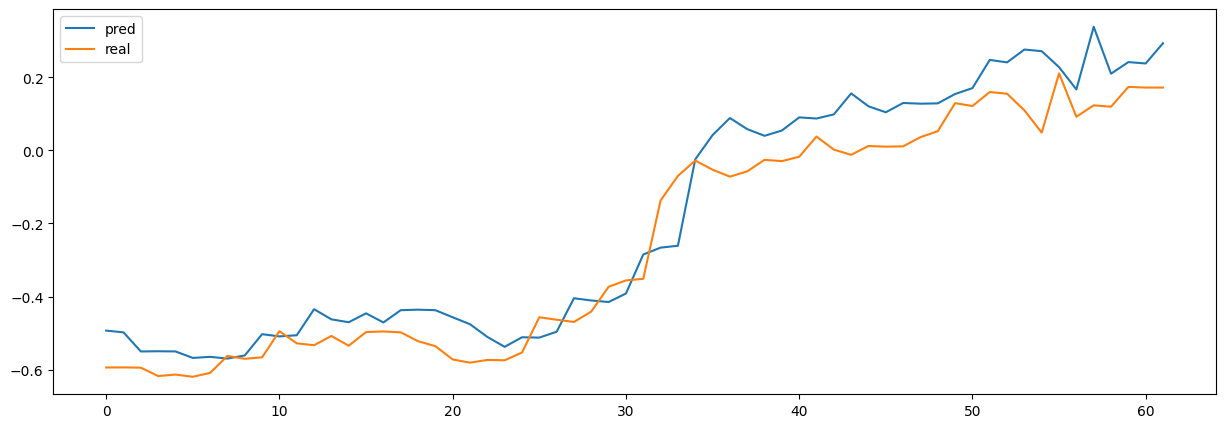

In [12]:
test_df.plot(figsize=(15,5))